# Introduction


This work analyzes the historic data of KSM, DOT and BTC in order to decide on security parameters for the Kintsugi bridge. The code is general enough such that inspecting a new collateral asset can be done with minimal effort.

Historic price data is gathered from Coingecko, while order book data is collected from the Binance API. Binance is preferred over the other centralized exchanges because it has by far the largest trading volume (https://coinmarketcap.com/rankings/exchanges/).

There are two approaches that have been combined to arrive at a secure configuration, each applied conservatively. One applies and improves on the approach from the Gudgeon et al's DeFi Crisis paper (https://arxiv.org/pdf/2002.08099.pdf), which models price trajectories as stochastic processes. The other, Value at Risk (VaR), is a well-established method of quantifying financial losses. 

The parameters comprising the security configuration are: DEBT_CEILING_USD, LIQUIDATION_THRESHOLD, SECURE_THRESHOLD. The bridge also uses a PREMIUM_REDEEM_THRESHOLD to increase system security, but premium redeems are assumed not to occur in order to better capture tail risk. Of the three parameters, the first two are selected using the stochastic simulation while the last one is selected using VaR. Given the secure threshold has little bearing on the output of the simulation, its value is determined by VaR to have 99% confidence that a single-day devaluation of the collateral asset will not take vaults below the liquidation threshold.

Vaults are modelled as a single entity that mints the maximum wrapped amount on the first simulated day, at the secure threshold. This is a pessimistic assumption aimed at fully stress-testing the system.

One step of the simulation generates multiple price trajectories for both the collateral and the wrapped asset. Then, the worst trajectory of the collateral asset is picked. To match historic observation, a price trajectory for the wrapped asset is selected to produce a correlation as close to the real one as possible.

If, on any day, vaults fall below the liquidation ratio, their entire collateral is seized by the liquidation vault, causing the 1:1 peg to be destabilised. This is because vaults no longer have something to lose when stealing the BTC in their wallet. At this point, the "debt" in the system can only be liquidated by arbitrageurs who burn wrapped tokens in exchange for collateral at a beneficial rate. How beneficial this rate is is initially decided by the liquidation threshold, but if the backing asset keeps decreasing in value arbitrage profits can reach zero. In the event that the liquidation vault becomes undercollateralized, the relative value of the wrapped tokens to BTC would be equal to the collateralization rate.

Another conservative assumption is that liquidators mint their own wrapped tokens, thus requiring liquidity in both collateral and BTC. Although Gudgeon et al's paper assumes liquidity is equal to the daily traded volume, this works takes the more thorough approach of training a transaction cost (slippage) model. This is also in spite of simpler solutions being available, such as incorporating the bid-ask spread to obtain a liquidity-adjusted VaR. The larger the debt ceiling in the bridge, the more likely it is that liquidiators will move the market, and the liquidity-adjusted VaR would not have captured this insight. For invidividual KSM trades, which achieve small volumes compared to DOT, there is close to zero correlation between buy order amount (buyer-is-taker) and price movement. However, correlation appears when consecutive buy order are considered (with no sells in-between). After some manual filtering, the slippage model is trained on the most extreme of these data points.

In a similar work, Gauntlet (https://medium.com/gauntlet-networks/karura-parameter-recommendation-methodology-6ce7fe06cb77) also train a price impact model to measure how quickly the market recovers after large trades. The many pessimistic assumptions made in this analysis are considered to suffice and price is considered to stabilise by the next day, following the aforementioned trajectory. 

Among the improvements to be made in the future are the training of a price impact model and the aggregation of order book data from multiple exchanges. Moreover, the impact of buying wrapped tokens with collateral tokens on decentralized exchanges can also be modelled, and a custom loss function should be implemented for sci-kit learn, that prioritises exreme data points.

Finally, the selected security configuration for Kintsugi is:
```
DEBT_CEILING_USD = 20_000_000
LIQUIDATION_THRESHOLD = 2.0
SECURE_THRESHOLD = 2.5
```

TODO:
- model intraday collateral price plummeting vs slippage from liquidators

# Data reading and processing

In [1]:
# Minutely data will be used for duration within 1 day, Hourly data will be used for duration between 1 day and 90 days, Daily data will be used for duration above 90 days.
# KSM/USD daily (01/01/2021 - 08/12/2021): https://api.coingecko.com/api/v3/coins/kusama/market_chart/range?vs_currency=usd&from=1609459200&to=1638963993
# DOT/USD daily (01/01/2021 - 08/12/2021): https://api.coingecko.com/api/v3/coins/polkadot/market_chart/range?vs_currency=usd&from=1609459200&to=1638963993
# Bitcoin/USD daily (01/01/2021 - 08/12/2021): https://api.coingecko.com/api/v3/coins/bitcoin/market_chart/range?vs_currency=usd&from=1609459200&to=1638963993
# `./download_trades` script made to download Binance data

In [2]:
%load_ext nb_black

import json
from scipy.stats import pearsonr
import math
import datetime

from sklearn import linear_model
from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt
import numpy as np
import statistics
import pandas as pd


def get_usd_timeseries(file):
    f = open(file)
    data = json.load(f)
    f.close()
    return [price for (timestamp, price) in data["prices"]]


def get_volume_timeseries(file):
    f = open(file)
    data = json.load(f)
    f.close()
    prices = get_usd_timeseries(file)
    volumes = []
    for i in range(len(data["total_volumes"])):
        (timestamp, usd_volume) = data["total_volumes"][i]
        volumes.append(usd_volume / prices[i])
    return volumes


def get_daily_volumes_dict(file):
    f = open(file)
    data = json.load(f)
    f.close()
    prices = get_usd_timeseries(file)
    volumes = dict()
    for i in range(len(data["total_volumes"])):
        (timestamp, usd_volume) = data["total_volumes"][i]
        volumes[timestamp] = usd_volume
    return volumes


def determine_price_between_assets(asset_1_prices, asset_2_prices):
    return [
        asset_1_price / asset_2_price
        for (asset_1_price, asset_2_price) in zip(asset_1_prices, asset_2_prices)
    ]


def prices_to_returns(prices):
    return [(prices[i] / prices[i - 1] - 1) for i in range(1, len(prices))]


def round_timestamp_to_nearest_gmt_date(unix_timestamp):
    import os

    date_format = "%d/%m/%Y"
    os.environ["TZ"] = "GMT"
    parsed_date = datetime.datetime.fromtimestamp(
        int(unix_timestamp) / 1000.0
    ).strftime(date_format)
    return (
        int(datetime.datetime.strptime(parsed_date, date_format).timestamp() + 3600)
        * 1000
    )


def read_trading_data(file):
    # Assumes Binance format
    # https://github.com/binance/binance-public-data/#trades
    names = [
        "trade_id",
        "price",
        "qty",
        "quote_qty",
        "time",
        "is_buyer_maker",
        "is_best_match",
    ]
    df = pd.read_csv(file, names=names)
    return df.drop(columns=["trade_id", "quote_qty", "is_best_match"])


def clean_trading_data_consecutively(
    trading_data, daily_volumes_dict, max_item_count, min_total_qty, min_price_change
):
    # simplify df to be ready for regression
    cleaned_df = pd.DataFrame(columns=["qty", "caused_price_change"])
    cleaned_df_index = 0
    prev_price = 1
    prev_qty = 0
    prev_nearest_date = 0
    prev_qty_to_volume_ratio = 0
    prev_is_buyer_maker = False
    i = -1
    while i < len(trading_data.index):
        i += 1
        row = trading_data.iloc[i]
        if row["is_buyer_maker"] == True:
            continue
        initial_price = row["price"]
        j = i
        total_qty = 0
        while row["is_buyer_maker"] == False and j < len(trading_data.index):
            row = trading_data.iloc[j]
            total_qty += row["qty"]
            j += 1
        price_change = (row["price"] / initial_price) - 1
        if i == j or total_qty < min_total_qty or price_change < min_price_change:
            continue
        cleaned_df.loc[cleaned_df_index] = [
            total_qty,
            price_change,
        ]
        cleaned_df_index += 1
        print("Added elements: " + str(cleaned_df_index))
        i = j
        if cleaned_df_index > max_item_count:
            break
    return cleaned_df


ksm_to_usd_daily = get_usd_timeseries("kusama_to_usd_daily_2021.json")
ksm_usd_returns_daily = prices_to_returns(ksm_to_usd_daily)

dot_to_usd_daily = get_usd_timeseries("polkadot_to_usd_daily_2021.json")
dot_usd_returns_daily = prices_to_returns(dot_to_usd_daily)

btc_to_usd_daily = get_usd_timeseries("bitcoin_to_usd_daily_2021.json")
btc_usd_returns_daily = prices_to_returns(btc_to_usd_daily)

ksm_to_btc_daily = determine_price_between_assets(ksm_to_usd_daily, btc_to_usd_daily)
ksm_to_btc_returns_daily = prices_to_returns(ksm_to_btc_daily)
observed_ksm_btc_corr, _ = pearsonr(ksm_usd_returns_daily, btc_usd_returns_daily)


dot_to_btc_daily = determine_price_between_assets(dot_to_usd_daily, btc_to_usd_daily)
dot_to_btc_returns_daily = prices_to_returns(dot_to_btc_daily)
observed_dot_btc_corr, _ = pearsonr(dot_usd_returns_daily, btc_usd_returns_daily)

ksm_daily_volumes = get_volume_timeseries("kusama_to_usd_daily_2021.json")
ksm_volumes_dict = get_daily_volumes_dict("kusama_to_usd_daily_2021.json")

dot_daily_volumes = get_volume_timeseries("polkadot_to_usd_daily_2021.json")
dot_volumes_dict = get_daily_volumes_dict("polkadot_to_usd_daily_2021.json")

btc_daily_volumes = get_volume_timeseries("bitcoin_to_usd_daily_2021.json")
btc_volumes_dict = get_daily_volumes_dict("bitcoin_to_usd_daily_2021.json")

print("KSM/BTC correlation is: " + str(observed_ksm_btc_corr))
print("DOT/BTC correlation is: " + str(observed_dot_btc_corr))

KSM/BTC correlation is: 0.5856267043200133
DOT/BTC correlation is: 0.6706932776980907


<IPython.core.display.Javascript object>

In [3]:
btc_raw_trading_data = read_trading_data("BTC_trades.csv")

<IPython.core.display.Javascript object>

In [4]:
# Filter data to only keep extreme cases, to train a conservative slippage model
btc_trading_data = clean_trading_data_consecutively(
    btc_raw_trading_data, btc_volumes_dict, 20, 5, 0.000001
)

Added elements: 1
Added elements: 2
Added elements: 3
Added elements: 4
Added elements: 5
Added elements: 6
Added elements: 7
Added elements: 8
Added elements: 9
Added elements: 10
Added elements: 11
Added elements: 12
Added elements: 13
Added elements: 14
Added elements: 15
Added elements: 16
Added elements: 17
Added elements: 18
Added elements: 19
Added elements: 20
Added elements: 21


<IPython.core.display.Javascript object>

In [5]:
ksm_raw_trading_data = read_trading_data("KSM_trades.csv")

<IPython.core.display.Javascript object>

In [6]:
# Filter data to only keep extreme cases, to train a conservative slippage model
ksm_trading_data = clean_trading_data_consecutively(
    ksm_raw_trading_data, ksm_volumes_dict, 10, 10, 0.006
)

Added elements: 1
Added elements: 2
Added elements: 3
Added elements: 4
Added elements: 5
Added elements: 6
Added elements: 7
Added elements: 8
Added elements: 9
Added elements: 10
Added elements: 11


<IPython.core.display.Javascript object>

In [7]:
# Filter data to only keep extreme cases, to train a conservative slippage model
ksm_trading_data_unfiltered = clean_trading_data_consecutively(
    ksm_raw_trading_data, ksm_volumes_dict, 10000, 0, -100
)
ksm_liquidity_model = get_regression_model(ksm_trading_data_unfiltered)

Added elements: 1
Added elements: 2
Added elements: 3
Added elements: 4
Added elements: 5
Added elements: 6
Added elements: 7
Added elements: 8
Added elements: 9
Added elements: 10
Added elements: 11
Added elements: 12
Added elements: 13
Added elements: 14
Added elements: 15
Added elements: 16
Added elements: 17
Added elements: 18
Added elements: 19
Added elements: 20
Added elements: 21
Added elements: 22
Added elements: 23
Added elements: 24
Added elements: 25
Added elements: 26
Added elements: 27
Added elements: 28
Added elements: 29
Added elements: 30
Added elements: 31
Added elements: 32
Added elements: 33
Added elements: 34
Added elements: 35
Added elements: 36
Added elements: 37
Added elements: 38
Added elements: 39
Added elements: 40
Added elements: 41
Added elements: 42
Added elements: 43
Added elements: 44
Added elements: 45
Added elements: 46
Added elements: 47
Added elements: 48
Added elements: 49
Added elements: 50
Added elements: 51
Added elements: 52
Added elements: 53
Ad

Added elements: 426
Added elements: 427
Added elements: 428
Added elements: 429
Added elements: 430
Added elements: 431
Added elements: 432
Added elements: 433
Added elements: 434
Added elements: 435
Added elements: 436
Added elements: 437
Added elements: 438
Added elements: 439
Added elements: 440
Added elements: 441
Added elements: 442
Added elements: 443
Added elements: 444
Added elements: 445
Added elements: 446
Added elements: 447
Added elements: 448
Added elements: 449
Added elements: 450
Added elements: 451
Added elements: 452
Added elements: 453
Added elements: 454
Added elements: 455
Added elements: 456
Added elements: 457
Added elements: 458
Added elements: 459
Added elements: 460
Added elements: 461
Added elements: 462
Added elements: 463
Added elements: 464
Added elements: 465
Added elements: 466
Added elements: 467
Added elements: 468
Added elements: 469
Added elements: 470
Added elements: 471
Added elements: 472
Added elements: 473
Added elements: 474
Added elements: 475


Added elements: 850
Added elements: 851
Added elements: 852
Added elements: 853
Added elements: 854
Added elements: 855
Added elements: 856
Added elements: 857
Added elements: 858
Added elements: 859
Added elements: 860
Added elements: 861
Added elements: 862
Added elements: 863
Added elements: 864
Added elements: 865
Added elements: 866
Added elements: 867
Added elements: 868
Added elements: 869
Added elements: 870
Added elements: 871
Added elements: 872
Added elements: 873
Added elements: 874
Added elements: 875
Added elements: 876
Added elements: 877
Added elements: 878
Added elements: 879
Added elements: 880
Added elements: 881
Added elements: 882
Added elements: 883
Added elements: 884
Added elements: 885
Added elements: 886
Added elements: 887
Added elements: 888
Added elements: 889
Added elements: 890
Added elements: 891
Added elements: 892
Added elements: 893
Added elements: 894
Added elements: 895
Added elements: 896
Added elements: 897
Added elements: 898
Added elements: 899


Added elements: 1322
Added elements: 1323
Added elements: 1324
Added elements: 1325
Added elements: 1326
Added elements: 1327
Added elements: 1328
Added elements: 1329
Added elements: 1330
Added elements: 1331
Added elements: 1332
Added elements: 1333
Added elements: 1334
Added elements: 1335
Added elements: 1336
Added elements: 1337
Added elements: 1338
Added elements: 1339
Added elements: 1340
Added elements: 1341
Added elements: 1342
Added elements: 1343
Added elements: 1344
Added elements: 1345
Added elements: 1346
Added elements: 1347
Added elements: 1348
Added elements: 1349
Added elements: 1350
Added elements: 1351
Added elements: 1352
Added elements: 1353
Added elements: 1354
Added elements: 1355
Added elements: 1356
Added elements: 1357
Added elements: 1358
Added elements: 1359
Added elements: 1360
Added elements: 1361
Added elements: 1362
Added elements: 1363
Added elements: 1364
Added elements: 1365
Added elements: 1366
Added elements: 1367
Added elements: 1368
Added element

Added elements: 1759
Added elements: 1760
Added elements: 1761
Added elements: 1762
Added elements: 1763
Added elements: 1764
Added elements: 1765
Added elements: 1766
Added elements: 1767
Added elements: 1768
Added elements: 1769
Added elements: 1770
Added elements: 1771
Added elements: 1772
Added elements: 1773
Added elements: 1774
Added elements: 1775
Added elements: 1776
Added elements: 1777
Added elements: 1778
Added elements: 1779
Added elements: 1780
Added elements: 1781
Added elements: 1782
Added elements: 1783
Added elements: 1784
Added elements: 1785
Added elements: 1786
Added elements: 1787
Added elements: 1788
Added elements: 1789
Added elements: 1790
Added elements: 1791
Added elements: 1792
Added elements: 1793
Added elements: 1794
Added elements: 1795
Added elements: 1796
Added elements: 1797
Added elements: 1798
Added elements: 1799
Added elements: 1800
Added elements: 1801
Added elements: 1802
Added elements: 1803
Added elements: 1804
Added elements: 1805
Added element

Added elements: 2213
Added elements: 2214
Added elements: 2215
Added elements: 2216
Added elements: 2217
Added elements: 2218
Added elements: 2219
Added elements: 2220
Added elements: 2221
Added elements: 2222
Added elements: 2223
Added elements: 2224
Added elements: 2225
Added elements: 2226
Added elements: 2227
Added elements: 2228
Added elements: 2229
Added elements: 2230
Added elements: 2231
Added elements: 2232
Added elements: 2233
Added elements: 2234
Added elements: 2235
Added elements: 2236
Added elements: 2237
Added elements: 2238
Added elements: 2239
Added elements: 2240
Added elements: 2241
Added elements: 2242
Added elements: 2243
Added elements: 2244
Added elements: 2245
Added elements: 2246
Added elements: 2247
Added elements: 2248
Added elements: 2249
Added elements: 2250
Added elements: 2251
Added elements: 2252
Added elements: 2253
Added elements: 2254
Added elements: 2255
Added elements: 2256
Added elements: 2257
Added elements: 2258
Added elements: 2259
Added element

Added elements: 2693
Added elements: 2694
Added elements: 2695
Added elements: 2696
Added elements: 2697
Added elements: 2698
Added elements: 2699
Added elements: 2700
Added elements: 2701
Added elements: 2702
Added elements: 2703
Added elements: 2704
Added elements: 2705
Added elements: 2706
Added elements: 2707
Added elements: 2708
Added elements: 2709
Added elements: 2710
Added elements: 2711
Added elements: 2712
Added elements: 2713
Added elements: 2714
Added elements: 2715
Added elements: 2716
Added elements: 2717
Added elements: 2718
Added elements: 2719
Added elements: 2720
Added elements: 2721
Added elements: 2722
Added elements: 2723
Added elements: 2724
Added elements: 2725
Added elements: 2726
Added elements: 2727
Added elements: 2728
Added elements: 2729
Added elements: 2730
Added elements: 2731
Added elements: 2732
Added elements: 2733
Added elements: 2734
Added elements: 2735
Added elements: 2736
Added elements: 2737
Added elements: 2738
Added elements: 2739
Added element

Added elements: 3130
Added elements: 3131
Added elements: 3132
Added elements: 3133
Added elements: 3134
Added elements: 3135
Added elements: 3136
Added elements: 3137
Added elements: 3138
Added elements: 3139
Added elements: 3140
Added elements: 3141
Added elements: 3142
Added elements: 3143
Added elements: 3144
Added elements: 3145
Added elements: 3146
Added elements: 3147
Added elements: 3148
Added elements: 3149
Added elements: 3150
Added elements: 3151
Added elements: 3152
Added elements: 3153
Added elements: 3154
Added elements: 3155
Added elements: 3156
Added elements: 3157
Added elements: 3158
Added elements: 3159
Added elements: 3160
Added elements: 3161
Added elements: 3162
Added elements: 3163
Added elements: 3164
Added elements: 3165
Added elements: 3166
Added elements: 3167
Added elements: 3168
Added elements: 3169
Added elements: 3170
Added elements: 3171
Added elements: 3172
Added elements: 3173
Added elements: 3174
Added elements: 3175
Added elements: 3176
Added element

Added elements: 3560
Added elements: 3561
Added elements: 3562
Added elements: 3563
Added elements: 3564
Added elements: 3565
Added elements: 3566
Added elements: 3567
Added elements: 3568
Added elements: 3569
Added elements: 3570
Added elements: 3571
Added elements: 3572
Added elements: 3573
Added elements: 3574
Added elements: 3575
Added elements: 3576
Added elements: 3577
Added elements: 3578
Added elements: 3579
Added elements: 3580
Added elements: 3581
Added elements: 3582
Added elements: 3583
Added elements: 3584
Added elements: 3585
Added elements: 3586
Added elements: 3587
Added elements: 3588
Added elements: 3589
Added elements: 3590
Added elements: 3591
Added elements: 3592
Added elements: 3593
Added elements: 3594
Added elements: 3595
Added elements: 3596
Added elements: 3597
Added elements: 3598
Added elements: 3599
Added elements: 3600
Added elements: 3601
Added elements: 3602
Added elements: 3603
Added elements: 3604
Added elements: 3605
Added elements: 3606
Added element

Added elements: 4009
Added elements: 4010
Added elements: 4011
Added elements: 4012
Added elements: 4013
Added elements: 4014
Added elements: 4015
Added elements: 4016
Added elements: 4017
Added elements: 4018
Added elements: 4019
Added elements: 4020
Added elements: 4021
Added elements: 4022
Added elements: 4023
Added elements: 4024
Added elements: 4025
Added elements: 4026
Added elements: 4027
Added elements: 4028
Added elements: 4029
Added elements: 4030
Added elements: 4031
Added elements: 4032
Added elements: 4033
Added elements: 4034
Added elements: 4035
Added elements: 4036
Added elements: 4037
Added elements: 4038
Added elements: 4039
Added elements: 4040
Added elements: 4041
Added elements: 4042
Added elements: 4043
Added elements: 4044
Added elements: 4045
Added elements: 4046
Added elements: 4047
Added elements: 4048
Added elements: 4049
Added elements: 4050
Added elements: 4051
Added elements: 4052
Added elements: 4053
Added elements: 4054
Added elements: 4055
Added element

Added elements: 4429
Added elements: 4430
Added elements: 4431
Added elements: 4432
Added elements: 4433
Added elements: 4434
Added elements: 4435
Added elements: 4436
Added elements: 4437
Added elements: 4438
Added elements: 4439
Added elements: 4440
Added elements: 4441
Added elements: 4442
Added elements: 4443
Added elements: 4444
Added elements: 4445
Added elements: 4446
Added elements: 4447
Added elements: 4448
Added elements: 4449
Added elements: 4450
Added elements: 4451
Added elements: 4452
Added elements: 4453
Added elements: 4454
Added elements: 4455
Added elements: 4456
Added elements: 4457
Added elements: 4458
Added elements: 4459
Added elements: 4460
Added elements: 4461
Added elements: 4462
Added elements: 4463
Added elements: 4464
Added elements: 4465
Added elements: 4466
Added elements: 4467
Added elements: 4468
Added elements: 4469
Added elements: 4470
Added elements: 4471
Added elements: 4472
Added elements: 4473
Added elements: 4474
Added elements: 4475
Added element

Added elements: 4841
Added elements: 4842
Added elements: 4843
Added elements: 4844
Added elements: 4845
Added elements: 4846
Added elements: 4847
Added elements: 4848
Added elements: 4849
Added elements: 4850
Added elements: 4851
Added elements: 4852
Added elements: 4853
Added elements: 4854
Added elements: 4855
Added elements: 4856
Added elements: 4857
Added elements: 4858
Added elements: 4859
Added elements: 4860
Added elements: 4861
Added elements: 4862
Added elements: 4863
Added elements: 4864
Added elements: 4865
Added elements: 4866
Added elements: 4867
Added elements: 4868
Added elements: 4869
Added elements: 4870
Added elements: 4871
Added elements: 4872
Added elements: 4873
Added elements: 4874
Added elements: 4875
Added elements: 4876
Added elements: 4877
Added elements: 4878
Added elements: 4879
Added elements: 4880
Added elements: 4881
Added elements: 4882
Added elements: 4883
Added elements: 4884
Added elements: 4885
Added elements: 4886
Added elements: 4887
Added element

Added elements: 5297
Added elements: 5298
Added elements: 5299
Added elements: 5300
Added elements: 5301
Added elements: 5302
Added elements: 5303
Added elements: 5304
Added elements: 5305
Added elements: 5306
Added elements: 5307
Added elements: 5308
Added elements: 5309
Added elements: 5310
Added elements: 5311
Added elements: 5312
Added elements: 5313
Added elements: 5314
Added elements: 5315
Added elements: 5316
Added elements: 5317
Added elements: 5318
Added elements: 5319
Added elements: 5320
Added elements: 5321
Added elements: 5322
Added elements: 5323
Added elements: 5324
Added elements: 5325
Added elements: 5326
Added elements: 5327
Added elements: 5328
Added elements: 5329
Added elements: 5330
Added elements: 5331
Added elements: 5332
Added elements: 5333
Added elements: 5334
Added elements: 5335
Added elements: 5336
Added elements: 5337
Added elements: 5338
Added elements: 5339
Added elements: 5340
Added elements: 5341
Added elements: 5342
Added elements: 5343
Added element

Added elements: 5710
Added elements: 5711
Added elements: 5712
Added elements: 5713
Added elements: 5714
Added elements: 5715
Added elements: 5716
Added elements: 5717
Added elements: 5718
Added elements: 5719
Added elements: 5720
Added elements: 5721
Added elements: 5722
Added elements: 5723
Added elements: 5724
Added elements: 5725
Added elements: 5726
Added elements: 5727
Added elements: 5728
Added elements: 5729
Added elements: 5730
Added elements: 5731
Added elements: 5732
Added elements: 5733
Added elements: 5734
Added elements: 5735
Added elements: 5736
Added elements: 5737
Added elements: 5738
Added elements: 5739
Added elements: 5740
Added elements: 5741
Added elements: 5742
Added elements: 5743
Added elements: 5744
Added elements: 5745
Added elements: 5746
Added elements: 5747
Added elements: 5748
Added elements: 5749
Added elements: 5750
Added elements: 5751
Added elements: 5752
Added elements: 5753
Added elements: 5754
Added elements: 5755
Added elements: 5756
Added element

Added elements: 6116
Added elements: 6117
Added elements: 6118
Added elements: 6119
Added elements: 6120
Added elements: 6121
Added elements: 6122
Added elements: 6123
Added elements: 6124
Added elements: 6125
Added elements: 6126
Added elements: 6127
Added elements: 6128
Added elements: 6129
Added elements: 6130
Added elements: 6131
Added elements: 6132
Added elements: 6133
Added elements: 6134
Added elements: 6135
Added elements: 6136
Added elements: 6137
Added elements: 6138
Added elements: 6139
Added elements: 6140
Added elements: 6141
Added elements: 6142
Added elements: 6143
Added elements: 6144
Added elements: 6145
Added elements: 6146
Added elements: 6147
Added elements: 6148
Added elements: 6149
Added elements: 6150
Added elements: 6151
Added elements: 6152
Added elements: 6153
Added elements: 6154
Added elements: 6155
Added elements: 6156
Added elements: 6157
Added elements: 6158
Added elements: 6159
Added elements: 6160
Added elements: 6161
Added elements: 6162
Added element

Added elements: 6559
Added elements: 6560
Added elements: 6561
Added elements: 6562
Added elements: 6563
Added elements: 6564
Added elements: 6565
Added elements: 6566
Added elements: 6567
Added elements: 6568
Added elements: 6569
Added elements: 6570
Added elements: 6571
Added elements: 6572
Added elements: 6573
Added elements: 6574
Added elements: 6575
Added elements: 6576
Added elements: 6577
Added elements: 6578
Added elements: 6579
Added elements: 6580
Added elements: 6581
Added elements: 6582
Added elements: 6583
Added elements: 6584
Added elements: 6585
Added elements: 6586
Added elements: 6587
Added elements: 6588
Added elements: 6589
Added elements: 6590
Added elements: 6591
Added elements: 6592
Added elements: 6593
Added elements: 6594
Added elements: 6595
Added elements: 6596
Added elements: 6597
Added elements: 6598
Added elements: 6599
Added elements: 6600
Added elements: 6601
Added elements: 6602
Added elements: 6603
Added elements: 6604
Added elements: 6605
Added element

Added elements: 7016
Added elements: 7017
Added elements: 7018
Added elements: 7019
Added elements: 7020
Added elements: 7021
Added elements: 7022
Added elements: 7023
Added elements: 7024
Added elements: 7025
Added elements: 7026
Added elements: 7027
Added elements: 7028
Added elements: 7029
Added elements: 7030
Added elements: 7031
Added elements: 7032
Added elements: 7033
Added elements: 7034
Added elements: 7035
Added elements: 7036
Added elements: 7037
Added elements: 7038
Added elements: 7039
Added elements: 7040
Added elements: 7041
Added elements: 7042
Added elements: 7043
Added elements: 7044
Added elements: 7045
Added elements: 7046
Added elements: 7047
Added elements: 7048
Added elements: 7049
Added elements: 7050
Added elements: 7051
Added elements: 7052
Added elements: 7053
Added elements: 7054
Added elements: 7055
Added elements: 7056
Added elements: 7057
Added elements: 7058
Added elements: 7059
Added elements: 7060
Added elements: 7061
Added elements: 7062
Added element

Added elements: 7478
Added elements: 7479
Added elements: 7480
Added elements: 7481
Added elements: 7482
Added elements: 7483
Added elements: 7484
Added elements: 7485
Added elements: 7486
Added elements: 7487
Added elements: 7488
Added elements: 7489
Added elements: 7490
Added elements: 7491
Added elements: 7492
Added elements: 7493
Added elements: 7494
Added elements: 7495
Added elements: 7496
Added elements: 7497
Added elements: 7498
Added elements: 7499
Added elements: 7500
Added elements: 7501
Added elements: 7502
Added elements: 7503
Added elements: 7504
Added elements: 7505
Added elements: 7506
Added elements: 7507
Added elements: 7508
Added elements: 7509
Added elements: 7510
Added elements: 7511
Added elements: 7512
Added elements: 7513
Added elements: 7514
Added elements: 7515
Added elements: 7516
Added elements: 7517
Added elements: 7518
Added elements: 7519
Added elements: 7520
Added elements: 7521
Added elements: 7522
Added elements: 7523
Added elements: 7524
Added element

Added elements: 7947
Added elements: 7948
Added elements: 7949
Added elements: 7950
Added elements: 7951
Added elements: 7952
Added elements: 7953
Added elements: 7954
Added elements: 7955
Added elements: 7956
Added elements: 7957
Added elements: 7958
Added elements: 7959
Added elements: 7960
Added elements: 7961
Added elements: 7962
Added elements: 7963
Added elements: 7964
Added elements: 7965
Added elements: 7966
Added elements: 7967
Added elements: 7968
Added elements: 7969
Added elements: 7970
Added elements: 7971
Added elements: 7972
Added elements: 7973
Added elements: 7974
Added elements: 7975
Added elements: 7976
Added elements: 7977
Added elements: 7978
Added elements: 7979
Added elements: 7980
Added elements: 7981
Added elements: 7982
Added elements: 7983
Added elements: 7984
Added elements: 7985
Added elements: 7986
Added elements: 7987
Added elements: 7988
Added elements: 7989
Added elements: 7990
Added elements: 7991
Added elements: 7992
Added elements: 7993
Added element

Added elements: 8389
Added elements: 8390
Added elements: 8391
Added elements: 8392
Added elements: 8393
Added elements: 8394
Added elements: 8395
Added elements: 8396
Added elements: 8397
Added elements: 8398
Added elements: 8399
Added elements: 8400
Added elements: 8401
Added elements: 8402
Added elements: 8403
Added elements: 8404
Added elements: 8405
Added elements: 8406
Added elements: 8407
Added elements: 8408
Added elements: 8409
Added elements: 8410
Added elements: 8411
Added elements: 8412
Added elements: 8413
Added elements: 8414
Added elements: 8415
Added elements: 8416
Added elements: 8417
Added elements: 8418
Added elements: 8419
Added elements: 8420
Added elements: 8421
Added elements: 8422
Added elements: 8423
Added elements: 8424
Added elements: 8425
Added elements: 8426
Added elements: 8427
Added elements: 8428
Added elements: 8429
Added elements: 8430
Added elements: 8431
Added elements: 8432
Added elements: 8433
Added elements: 8434
Added elements: 8435
Added element

Added elements: 8789
Added elements: 8790
Added elements: 8791
Added elements: 8792
Added elements: 8793
Added elements: 8794
Added elements: 8795
Added elements: 8796
Added elements: 8797
Added elements: 8798
Added elements: 8799
Added elements: 8800
Added elements: 8801
Added elements: 8802
Added elements: 8803
Added elements: 8804
Added elements: 8805
Added elements: 8806
Added elements: 8807
Added elements: 8808
Added elements: 8809
Added elements: 8810
Added elements: 8811
Added elements: 8812
Added elements: 8813
Added elements: 8814
Added elements: 8815
Added elements: 8816
Added elements: 8817
Added elements: 8818
Added elements: 8819
Added elements: 8820
Added elements: 8821
Added elements: 8822
Added elements: 8823
Added elements: 8824
Added elements: 8825
Added elements: 8826
Added elements: 8827
Added elements: 8828
Added elements: 8829
Added elements: 8830
Added elements: 8831
Added elements: 8832
Added elements: 8833
Added elements: 8834
Added elements: 8835
Added element

Added elements: 9200
Added elements: 9201
Added elements: 9202
Added elements: 9203
Added elements: 9204
Added elements: 9205
Added elements: 9206
Added elements: 9207
Added elements: 9208
Added elements: 9209
Added elements: 9210
Added elements: 9211
Added elements: 9212
Added elements: 9213
Added elements: 9214
Added elements: 9215
Added elements: 9216
Added elements: 9217
Added elements: 9218
Added elements: 9219
Added elements: 9220
Added elements: 9221
Added elements: 9222
Added elements: 9223
Added elements: 9224
Added elements: 9225
Added elements: 9226
Added elements: 9227
Added elements: 9228
Added elements: 9229
Added elements: 9230
Added elements: 9231
Added elements: 9232
Added elements: 9233
Added elements: 9234
Added elements: 9235
Added elements: 9236
Added elements: 9237
Added elements: 9238
Added elements: 9239
Added elements: 9240
Added elements: 9241
Added elements: 9242
Added elements: 9243
Added elements: 9244
Added elements: 9245
Added elements: 9246
Added element

Added elements: 9610
Added elements: 9611
Added elements: 9612
Added elements: 9613
Added elements: 9614
Added elements: 9615
Added elements: 9616
Added elements: 9617
Added elements: 9618
Added elements: 9619
Added elements: 9620
Added elements: 9621
Added elements: 9622
Added elements: 9623
Added elements: 9624
Added elements: 9625
Added elements: 9626
Added elements: 9627
Added elements: 9628
Added elements: 9629
Added elements: 9630
Added elements: 9631
Added elements: 9632
Added elements: 9633
Added elements: 9634
Added elements: 9635
Added elements: 9636
Added elements: 9637
Added elements: 9638
Added elements: 9639
Added elements: 9640
Added elements: 9641
Added elements: 9642
Added elements: 9643
Added elements: 9644
Added elements: 9645
Added elements: 9646
Added elements: 9647
Added elements: 9648
Added elements: 9649
Added elements: 9650
Added elements: 9651
Added elements: 9652
Added elements: 9653
Added elements: 9654
Added elements: 9655
Added elements: 9656
Added element

NameError: name 'get_regression_model' is not defined

<IPython.core.display.Javascript object>

In [8]:
dot_raw_trading_data = read_trading_data("DOT_trades.csv")

<IPython.core.display.Javascript object>

In [9]:
# Filter data to only keep extreme case, to train a conservative slippage model
dot_trading_data = clean_trading_data_consecutively(
    dot_raw_trading_data, dot_volumes_dict, 50, 200, 0.0005
)

Added elements: 1
Added elements: 2
Added elements: 3
Added elements: 4
Added elements: 5
Added elements: 6
Added elements: 7
Added elements: 8
Added elements: 9
Added elements: 10
Added elements: 11
Added elements: 12
Added elements: 13
Added elements: 14
Added elements: 15
Added elements: 16
Added elements: 17
Added elements: 18
Added elements: 19
Added elements: 20
Added elements: 21
Added elements: 22
Added elements: 23
Added elements: 24
Added elements: 25
Added elements: 26
Added elements: 27
Added elements: 28
Added elements: 29
Added elements: 30
Added elements: 31
Added elements: 32
Added elements: 33
Added elements: 34
Added elements: 35
Added elements: 36
Added elements: 37
Added elements: 38
Added elements: 39
Added elements: 40
Added elements: 41
Added elements: 42
Added elements: 43
Added elements: 44
Added elements: 45
Added elements: 46
Added elements: 47
Added elements: 48
Added elements: 49
Added elements: 50
Added elements: 51


<IPython.core.display.Javascript object>

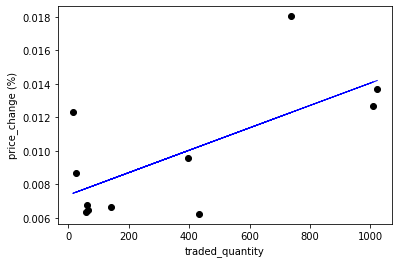

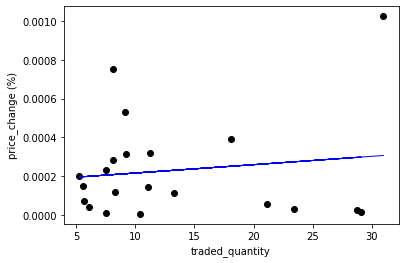

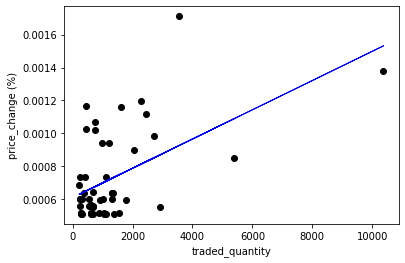

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
def get_regression_model(trading_data, min_price_change=None, max_qty=None):
    filtered_data = trading_data
    if min_price_change and max_qty:
        filtered_data = filtered_data[
            (filtered_data["caused_price_change"] > 0.01) & (filtered_data["qty"] < 400)
        ]
    x = filtered_data.qty.values
    y = filtered_data.caused_price_change.values

    x = x.reshape(len(x), 1)
    y = y.reshape(len(x), 1)

    regr = linear_model.LinearRegression()
    result = regr.fit(x, y)
    model = result.predict
    plt.scatter(x, y, color="black")
    plt.plot(x, model(x), color="blue", linewidth=1)
    plt.ylabel("price_change (%)")
    plt.xlabel("traded_quantity")
    plt.show()
    return model


ksm_liquidity_model = get_regression_model(ksm_trading_data)
btc_liquidity_model = get_regression_model(btc_trading_data)
dot_liquidity_model = get_regression_model(dot_trading_data)

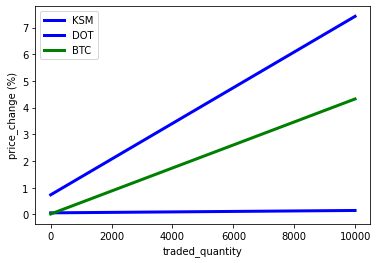

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
rng = np.arange(0, 10000).reshape(-1, 1)
plt.plot(rng, ksm_liquidity_model(rng) * 100, color="blue", linewidth=3, label="KSM")
plt.plot(rng, dot_liquidity_model(rng) * 100, color="blue", linewidth=3, label="DOT")
plt.plot(rng, btc_liquidity_model(rng) * 100, color="green", linewidth=3, label="BTC")
plt.ylabel("price_change (%)")
plt.xlabel("traded_quantity")
plt.legend()
plt.show()

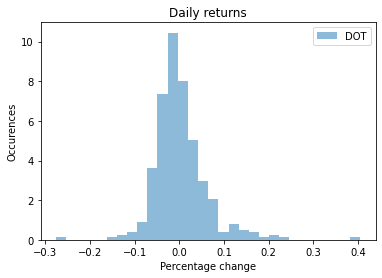

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
def plot_returns(returns, data_label, title):
    plt.hist(returns, density=True, bins=30, alpha=0.5, label=data_label)
    plt.ylabel("Occurences")
    plt.xlabel("Percentage change")
    plt.legend(loc="upper right")
    plt.title(title)


# plot_returns(ksm_to_btc_returns_daily, "KSM", "Daily returns")
plot_returns(dot_to_btc_returns_daily, "DOT", "Daily returns")

# Monte Carlo Simulation
https://arxiv.org/pdf/2002.08099.pdf

Independently simulates the prices of collateral and BTC.

Selects the worst collateral/USD price trajectory, then picks the BTC/USD price trajectory that has the closest pearson correlation to the one in the real data sample.

All vaults are considered a single entity, but they are separated from the liquidation vault. When vaults become undercollateralized, liquidators acquire as much liquidity as possible to arbitrage, taking slippage into account. Liquidators are assumed ot start up their own vault before liquidating, so both collateral and Bitcoin liquidity need to be modelled.

Even if slippage is considered, it is assumed that prices recover by the next day. While this is an optimistic assumption, the conservative slippage model balances it out.

In [36]:
# Should simulate more scenarios
SIMULATED_SCENARIOS = 100
PRICE_PATHS_PER_SIMULATION = 500
PREDICTED_TIME_STEPS = 100 * 24

# 6 blocks - assume 40 mins block confirmation time
BITCOIN_CONFIRMATION_HOURS = 4

# premium redeem is skipped
PREMIUM_REDEEM_BONUS = 0.05

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
# Monte Carlo price simulation (Geometric Brownian Motion)
# Reference article: https://towardsdatascience.com/simulating-stock-prices-in-python-using-geometric-brownian-motion-8dfd6e8c6b18


def stochastic_price_simulation(
    returns, initial_price, prediction_days, scenario_count
):
    So = initial_price
    dt = 1
    T = prediction_days
    N = T / dt
    t = np.arange(1, int(N) + 1)
    mu = np.mean(returns)
    sigma = np.std(returns)
    scen_size = scenario_count
    b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
    W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}

    # Calculating drift and diffusion components
    drift = (mu - 0.5 * sigma ** 2) * t
    diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}

    # Making the predictions
    S = np.array(
        [So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)]
    )
    S = np.hstack(
        (np.array([[So] for scen in range(scen_size)]), S)
    )  # add So to the beginning series

    # Plotting the simulations
    #     plt.figure(figsize=(20, 10))
    #     for i in range(scen_size):
    #         plt.title("Daily Volatility: " + str(sigma))
    #         plt.plot(S[i, :])
    #         plt.ylabel("Price")
    #         plt.xlabel("Prediction Days")
    #     plt.show()
    return S


def get_worst_price_trajectory(S):
    min_price = S[0, -1]
    index = 0
    for i in range(len(S)):
        if S[i, -1] < min_price:
            min_price = S[i, -1]
            index = i
    return S[index, :]


def get_trajectory_with_closest_correlation(S, base_trajectory, corr):
    picked_trajectory = S[0, :]
    index = 0
    closest_found_correlation, _ = pearsonr(base_trajectory, S[0, :])
    for i in range(len(S)):
        tmp_corr, _ = pearsonr(base_trajectory, S[i, :])
        if abs(tmp_corr - corr) < abs(closest_found_correlation - corr):
            closest_found_correlation = tmp_corr
            picked_trajectory = S[i, :]
            index = i
    return S[index, :], closest_found_correlation


def find_profitable_volume(
    secure_threshold,
    collateral_usd,
    btc_usd,
    collateral_liquidity_model,
    btc_liquidity_model,
    liquidation_vault_issued,
    liquidation_vault_collateral,
):
    btc_amount = liquidation_vault_issued
    while btc_amount > 0:
        collateral_amount = btc_amount * btc_usd / collateral_usd * secure_threshold
        btc_price_change = btc_liquidity_model([[btc_amount]])[0][0]
        collateral_price_change = collateral_liquidity_model([[collateral_amount]])[0][
            0
        ]
        new_btc_price = btc_usd * (1 + btc_price_change)
        new_collateral_price = collateral_usd * (1 + collateral_price_change)

        #         new_btc_price = btc_usd
        #         new_collateral_price = collateral_usd
        new_exchange_rate = new_collateral_price / new_btc_price
        burn_exchange_rate = (
            (liquidation_vault_collateral * new_collateral_price)
            / (liquidation_vault_issued * new_btc_price)
            * (new_collateral_price / new_btc_price)
        )
        if burn_exchange_rate >= new_exchange_rate:
            return btc_amount
        btc_amount -= 5
    return 0


def get_days_of_undercollateralization(
    worst_collateral_scenario_trajectory,
    correlated_btc_scenario_trajectory,
    collateral_liquidity_model,
    btc_liquidity_model,
    debt_ceiling_usd,
    secure_threshold,
    liquidation_threshold,
):
    starting_collateral_price = worst_collateral_scenario_trajectory[0]
    starting_btc_price = correlated_btc_scenario_trajectory[0]
    vaults_issued = (debt_ceiling_usd / secure_threshold) / starting_btc_price
    vaults_collateral = debt_ceiling_usd / starting_collateral_price

    liquidation_vault_issued = 0
    liquidation_vault_collateral = 0
    current_collateral_to_btc_price = starting_collateral_price / starting_btc_price

    system_collateral_daily = []
    vault_collateral_daily = []
    liquidation_vault_btc_daily = []
    daily_collateralization = []
    days_of_undercollateralization = 0

    time_periods_since_liquidation = 0

    for (collateral_usd, btc_usd) in zip(
        worst_collateral_scenario_trajectory, correlated_btc_scenario_trajectory
    ):
        current_collateral_to_btc_price = collateral_usd / btc_usd
        vault_required_collateral = vaults_issued / current_collateral_to_btc_price
        system_required_collateral = (
            vaults_issued + liquidation_vault_issued
        ) / current_collateral_to_btc_price
        system_collateral_daily.append(system_required_collateral)
        vault_collateral_daily.append(vaults_collateral)
        liquidation_vault_btc_daily.append(liquidation_vault_issued)
        system_collateralization = (
            vaults_collateral + liquidation_vault_collateral
        ) / system_required_collateral

        if (
            vaults_issued > 0
            and vaults_collateral / vault_required_collateral < liquidation_threshold
        ):
            # liquidate every vault
            liquidation_vault_issued = vaults_issued
            vaults_issued = 0
            liquidation_vault_collateral = vaults_collateral
            vaults_collateral = 0
            time_periods_since_liquidation = 0

        if time_periods_since_liquidation == BITCOIN_CONFIRMATION_HOURS:
            time_periods_since_liquidation = 0
            btc_arbitrage_amount = find_profitable_volume(
                secure_threshold,
                collateral_usd,
                btc_usd,
                collateral_liquidity_model,
                btc_liquidity_model,
                liquidation_vault_issued,
                liquidation_vault_collateral,
            )

            # mint interbtc for the liquidation
            newly_added_collateral = (
                btc_arbitrage_amount / current_collateral_to_btc_price
            ) * secure_threshold
            vaults_issued += btc_arbitrage_amount
            vaults_collateral += newly_added_collateral

            # perform burn redeem
            burn_exchange_rate = (
                (liquidation_vault_collateral * collateral_usd)
                / (liquidation_vault_issued * btc_usd)
                * current_collateral_to_btc_price
            )
            burn_dot_payout = btc_arbitrage_amount / burn_exchange_rate
            liquidation_vault_issued -= btc_arbitrage_amount
            liquidation_vault_collateral = round(
                liquidation_vault_collateral - burn_dot_payout
            )
        if liquidation_vault_issued > 0:
            time_periods_since_liquidation += 1
        daily_collateralization.append(system_collateralization)
        if system_collateralization < 1:
            days_of_undercollateralization += 1
    return (
        days_of_undercollateralization,
        daily_collateralization,
        liquidation_vault_btc_daily,
    )


def get_worst_pair_of_price_trajectories(
    scenarios_count,
    asset_corr,
    debt_ceiling_usd,
    secure_threshold,
    liquidation_threshold,
    collateral_usd_returns_daily,
    collateral_to_usd_daily,
    collateral_liquidity_model,
    btc_usd_returns_daily,
    btc_to_usd_daily,
    btc_liquidity_model,
):
    worst_btc_trajectory = []
    worst_collateral_trajectory = []
    most_days_of_undercollateralization = 0
    worst_daily_collateralization_trajectory = []
    worst_liquidation_vault_collateral_trajectory = []
    for i in range(scenarios_count):
        collateral_price_simulations = stochastic_price_simulation(
            collateral_usd_returns_daily,
            collateral_to_usd_daily[-1],
            PREDICTED_TIME_STEPS,
            PRICE_PATHS_PER_SIMULATION,
        )
        worst_collateral_scenario_trajectory = get_worst_price_trajectory(
            collateral_price_simulations
        )
        btc_price_simulations = stochastic_price_simulation(
            btc_usd_returns_daily,
            btc_to_usd_daily[-1],
            PREDICTED_TIME_STEPS,
            PRICE_PATHS_PER_SIMULATION,
        )
        (
            correlated_btc_scenario_trajectory,
            closest_found_correlation,
        ) = get_trajectory_with_closest_correlation(
            btc_price_simulations, worst_collateral_scenario_trajectory, asset_corr
        )
        (
            days_of_undercollateralization,
            daily_collateralization,
            liquidation_vault_btc_daily,
        ) = get_days_of_undercollateralization(
            worst_collateral_scenario_trajectory,
            correlated_btc_scenario_trajectory,
            collateral_liquidity_model,
            btc_liquidity_model,
            debt_ceiling_usd,
            secure_threshold,
            liquidation_threshold,
        )
        if (
            days_of_undercollateralization > most_days_of_undercollateralization
            or most_days_of_undercollateralization == 0
        ):
            most_days_of_undercollateralization = days_of_undercollateralization
            worst_btc_trajectory = correlated_btc_scenario_trajectory
            worst_collateral_trajectory = worst_collateral_scenario_trajectory
            worst_daily_collateralization_trajectory = daily_collateralization
            worst_liquidation_vault_collateral_trajectory = liquidation_vault_btc_daily
    return (
        worst_collateral_trajectory,
        worst_btc_trajectory,
        worst_daily_collateralization_trajectory,
        worst_liquidation_vault_collateral_trajectory,
        most_days_of_undercollateralization,
    )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
%reload_ext nb_black


def plot_collateralization(
    subplot,
    liquidation_vault_issued_daily,
    daily_collateralization,
    liquidation_threshold,
):
    subplot.plot([l / 1000 for l in liquidation_vault_issued_daily])
    subplot.plot(daily_collateralization)
    subplot.plot([liquidation_threshold] * len(daily_collateralization))
    subplot.plot([1.0] * len(daily_collateralization))
    subplot.legend(
        [
            "liquidation_vault_issued (thousands)",
            "collateralization",
            "liquidation threshold",
            "undercollateralization",
        ]
    )


def plot_prices(subplot, collateral_price_trajectory, btc_price_trajectory):
    subplot.plot([price * 1000 for price in collateral_price_trajectory])
    subplot.plot(btc_price_trajectory)
    subplot.legend(["collateral price (x1000)", "btc price"])


def simulate_and_plot(
    simulated_scenarios,
    observed_collateral_to_btc_corr,
    debt_ceiling_usd,
    secure_threshold,
    liquidation_threshold,
    collateral_usd_returns_daily,
    collateral_to_usd_daily,
    collateral_liquidity_model,
    btc_usd_returns_daily,
    btc_to_usd_daily,
    btc_liquidity_model,
):
    (
        collateral_price_trajectory,
        btc_price_trajectory,
        daily_collateralization,
        liquidation_vault_issued_daily,
        days_of_undercollateralization,
    ) = get_worst_pair_of_price_trajectories(
        simulated_scenarios,
        observed_collateral_to_btc_corr,
        debt_ceiling_usd,
        secure_threshold,
        liquidation_threshold,
        collateral_usd_returns_daily,
        collateral_to_usd_daily,
        collateral_liquidity_model,
        btc_usd_returns_daily,
        btc_to_usd_daily,
        btc_liquidity_model,
    )
    print("trajectory points:")
    print(len(collateral_price_trajectory))
    print("days of undercollateralization: " + str(days_of_undercollateralization))
    fig, axs = plt.subplots(2, figsize=(12, 10))
    plot_collateralization(
        axs[0],
        liquidation_vault_issued_daily,
        daily_collateralization,
        liquidation_threshold,
    )
    plot_prices(axs[1], collateral_price_trajectory, btc_price_trajectory)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

trajectory points:
2401
days of undercollateralization: 0


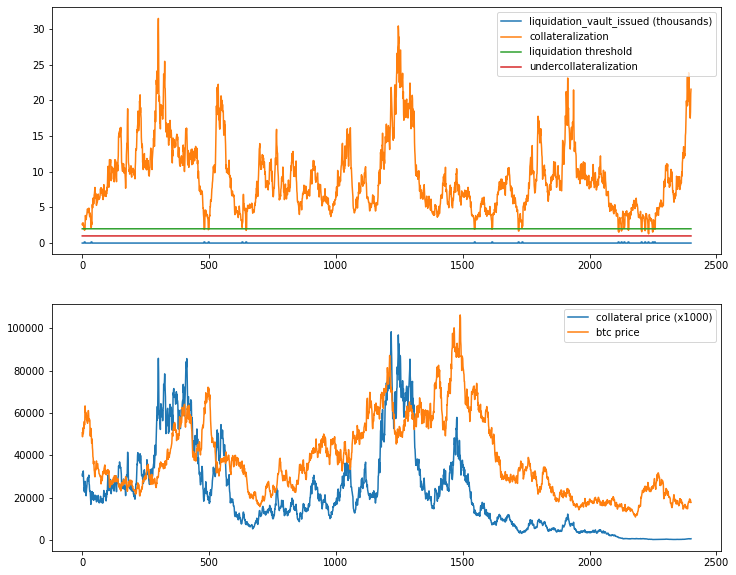

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
DEBT_CEILING_USD = 20_000_000
SECURE_THRESHOLD = 2.6
LIQUIDATION_THRESHOLD = 2.0
simulate_and_plot(
    SIMULATED_SCENARIOS,
    observed_ksm_btc_corr,
    DEBT_CEILING_USD,
    SECURE_THRESHOLD,
    LIQUIDATION_THRESHOLD,
    dot_usd_returns_daily,
    dot_to_usd_daily,
    dot_liquidity_model,
    btc_usd_returns_daily,
    btc_to_usd_daily,
    btc_liquidity_model,
)

trajectory points:
2401
days of undercollateralization: 6


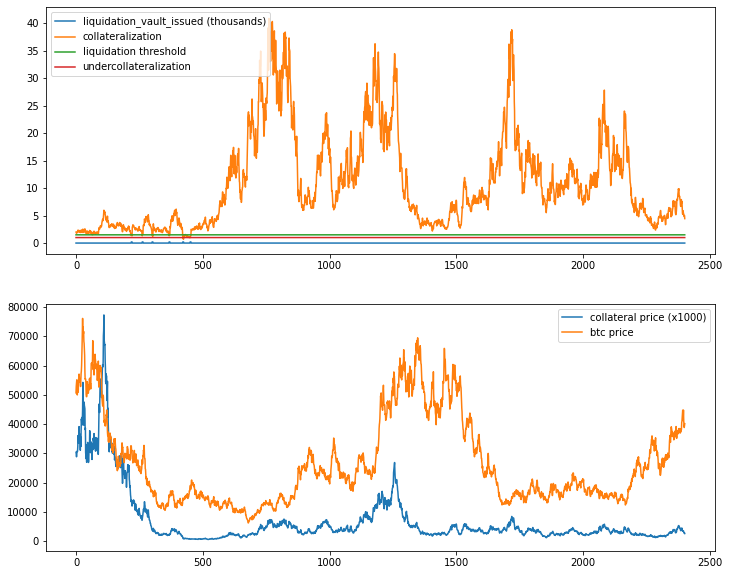

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [45]:
DEBT_CEILING_USD = 20_000_000
SECURE_THRESHOLD = 2.0
LIQUIDATION_THRESHOLD = 1.5
simulate_and_plot(
    SIMULATED_SCENARIOS,
    observed_ksm_btc_corr,
    DEBT_CEILING_USD,
    SECURE_THRESHOLD,
    LIQUIDATION_THRESHOLD,
    dot_usd_returns_daily,
    dot_to_usd_daily,
    dot_liquidity_model,
    btc_usd_returns_daily,
    btc_to_usd_daily,
    btc_liquidity_model,
)

trajectory points:
2401
days of undercollateralization: 1


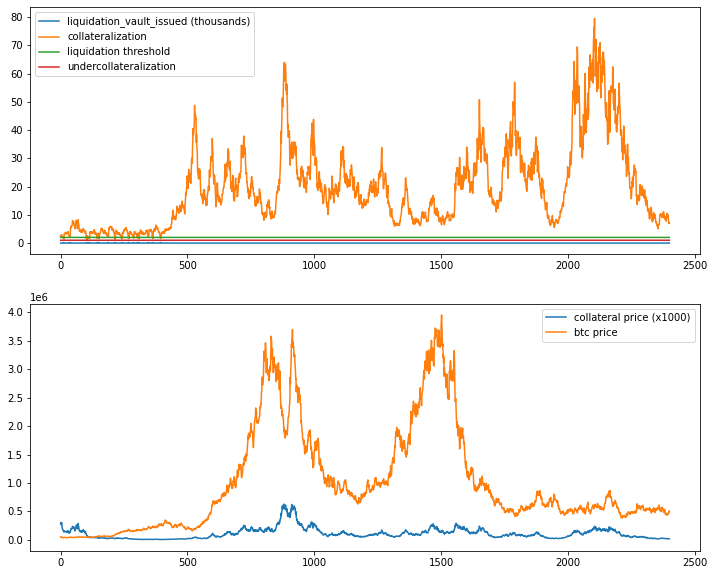

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [48]:
DEBT_CEILING_USD = 20_000_000
SECURE_THRESHOLD = 2.5
LIQUIDATION_THRESHOLD = 2.0
simulate_and_plot(
    SIMULATED_SCENARIOS,
    observed_ksm_btc_corr,
    DEBT_CEILING_USD,
    SECURE_THRESHOLD,
    LIQUIDATION_THRESHOLD,
    ksm_usd_returns_daily,
    ksm_to_usd_daily,
    ksm_liquidity_model,
    btc_usd_returns_daily,
    btc_to_usd_daily,
    btc_liquidity_model,
)

trajectory points:
2401
days of undercollateralization: 0


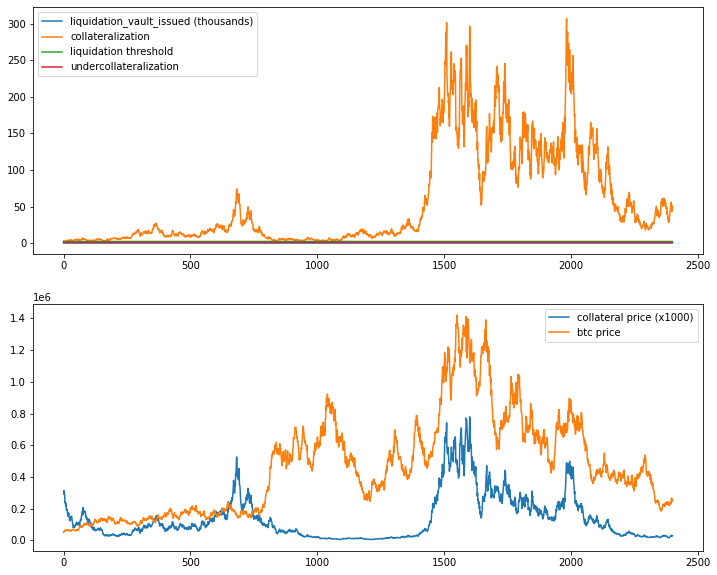

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [49]:
DEBT_CEILING_USD = 20_000_000
SECURE_THRESHOLD = 2.8
LIQUIDATION_THRESHOLD = 2.2
simulate_and_plot(
    SIMULATED_SCENARIOS,
    observed_ksm_btc_corr,
    DEBT_CEILING_USD,
    SECURE_THRESHOLD,
    LIQUIDATION_THRESHOLD,
    ksm_usd_returns_daily,
    ksm_to_usd_daily,
    ksm_liquidity_model,
    btc_usd_returns_daily,
    btc_to_usd_daily,
    btc_liquidity_model,
)

# Value At Risk (VAR) Model
https://ocw.mit.edu/courses/mathematics/18-s096-topics-in-mathematics-with-applications-in-finance-fall-2013/lecture-notes/MIT18_S096F13_lecnote7.pdf

In [58]:
def get_var(bid_ask_spread, threshold, daily_returns):
    confidence_99_9 = 3.29
    confidence_99 = 2.57
    confidence_95 = 1.96
    # Compute stddev using the daily returns, as these have higher volatility
    # VaR occasionally underestimates the number of large market moves.
    # Could consider a higher confidence interval to be on the safe side
    std_dev = statistics.pstdev(daily_returns)
    expected_loss_percentage_99_9 = confidence_99_9 * std_dev * (bid_ask_spread / 2 + 1)
    expected_loss_percentage_99 = confidence_99 * std_dev * (bid_ask_spread / 2 + 1)
    expected_loss_percentage_95 = confidence_95 * std_dev * (bid_ask_spread / 2 + 1)
    print(
        "99.9% confidence interval max price drop (%): "
        + str(expected_loss_percentage_99_9 * 100)
    )
    required_collateralization_99_9 = threshold / (1 - expected_loss_percentage_99_9)
    required_collateralization_99 = threshold / (1 - expected_loss_percentage_99)
    required_collateralization_95 = threshold / (1 - expected_loss_percentage_95)
    print("Liquidation threshold assumption: " + str(threshold))
    print(
        "Required collateralization (99.9% confidence interval): "
        + str(required_collateralization_99_9)
    )
    print(
        "Required collateralization (99% confidence interval): "
        + str(required_collateralization_99)
    )
    print(
        "Required collateralization (95% confidence interval): "
        + str(required_collateralization_95)
    )


DOT_BTC_bid_ask_spread = 0.001
DOT_PREMIUM_REDEEM_THRESHOLD = 2.6
print("DOT VaR results")
get_var(DOT_BTC_bid_ask_spread, DOT_PREMIUM_REDEEM_THRESHOLD, dot_to_btc_returns_daily)
print()
print("KSM VaR results")
KSM_BTC_bid_ask_spread = 0.003
KSM_PREMIUM_REDEEM_THRESHOLD = 2.8
get_var(KSM_BTC_bid_ask_spread, KSM_PREMIUM_REDEEM_THRESHOLD, ksm_to_btc_returns_daily)

DOT VaR results
99.9% confidence interval max price drop (%): 19.542940371123173
Liquidation threshold assumption: 2.6
Required collateralization (99.9% confidence interval): 3.2315374337478704
Required collateralization (99% confidence interval): 3.0684282832872705
Required collateralization (95% confidence interval): 2.942594600606168

KSM VaR results
99.9% confidence interval max price drop (%): 22.06529964569
Liquidation threshold assumption: 2.8
Required collateralization (99.9% confidence interval): 3.592751351157472
Required collateralization (99% confidence interval): 3.3831305779788847
Required collateralization (95% confidence interval): 3.2237743185558307


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [59]:
# Selected parameters DOT
# DEBT_CEILING_USD = 20_000_000

SECURE_THRESHOLD = 3.3
PREMIUM_REDEEM_THRESHOLD = 2.6
LIQUIDATION_THRESHOLD = 2.0

# Selected parameters KSM
# DEBT_CEILING_USD = 20_000_000

SECURE_THRESHOLD = 3.6
PREMIUM_REDEEM_THRESHOLD = 2.8
LIQUIDATION_THRESHOLD = 2.2

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>